In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import joblib
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
data= pd.read_csv("AgricultureData.csv")
data.head()

,product_id,product_name,category,price_per_kg,units_shipped_kg,units_sold_kg,units_on_hand_kg,supplier,farm_location,sale_date
0,b12c721e-8301-4b08-8ac3-d435be9b8b32,Lamb,Livestock,14.10,19224,14905,4319,Organic Meats Co.,"O'Reillyboro, OR",2022-07-04
1,4a0f8862-c851-4073-bc17-3a3d93834902,Beef,Livestock,11.37,29504,4550,24954,Organic Meats Co.,"Lake Nora, AR",2023-10-21
2,be996df6-1780-4352-8b7d-1f927279aa49,Oranges,Fruits,2.59,1838,1722,116,Berry Fields,"East Friedaside, NM",2023-12-24
3,6c8adfc3-2114-4b78-a3e2-2269a6a0dc02,Milk,Dairy,1.34,6750,1232,5518,Fresh Dairy Farms,"East Javon, FL",2023-12-25
4,0bd5bf2b-be0a-4ba0-aa92-059021b169e3,Bananas,Fruits,1.78,48729,47020,1709,Golden Orchards,"Lake D'angelo, MN",2023-06-20


In [3]:
data= data.drop(columns=['product_id','supplier','farm_location'])
data.head()

,product_name,category,price_per_kg,units_shipped_kg,units_sold_kg,units_on_hand_kg,sale_date
0,Lamb,Livestock,14.10,19224,14905,4319,2022-07-04
1,Beef,Livestock,11.37,29504,4550,24954,2023-10-21
2,Oranges,Fruits,2.59,1838,1722,116,2023-12-24
3,Milk,Dairy,1.34,6750,1232,5518,2023-12-25
4,Bananas,Fruits,1.78,48729,47020,1709,2023-06-20


In [4]:
data['sale_date']= pd.to_datetime(data['sale_date'])
data['month'] = data['sale_date'].dt.month

# Calculate total revenue and remaining stock
data["total_revenue"] = data["units_sold_kg"] * data["price_per_kg"]

data["sold_ratio"]= data['units_sold_kg']/data['units_shipped_kg']

data = data.drop(columns=["sale_date","units_sold_kg","price_per_kg","units_shipped_kg","units_on_hand_kg"])
print(data.head())


  product_name   category  month  total_revenue  sold_ratio
0         Lamb  Livestock      7      210160.50    0.775333
1         Beef  Livestock     10       51733.50    0.154216
2      Oranges     Fruits     12        4459.98    0.936888
3         Milk      Dairy     12        1650.88    0.182519
4      Bananas     Fruits      6       83695.60    0.964928


In [5]:
grouped_data = data.groupby(["product_name", "month"]).agg({
    "category": "first",
    "total_revenue": "sum",  # Sum up total revenue
    "sold_ratio": "mean",  # Take the average of sold ratio
}).reset_index()

print(grouped_data.head())

  product_name  month category  total_revenue  sold_ratio
0       Apples      1   Fruits      587248.86    0.500546
1       Apples      2   Fruits      573436.14    0.466295
2       Apples      3   Fruits      726427.24    0.540702
3       Apples      4   Fruits      561659.60    0.370205
4       Apples      5   Fruits      740374.36    0.460657


In [6]:
data_cleaned = grouped_data.dropna()
print(data_cleaned)

    product_name  month category  total_revenue  sold_ratio
0         Apples      1   Fruits      587248.86    0.500546
1         Apples      2   Fruits      573436.14    0.466295
2         Apples      3   Fruits      726427.24    0.540702
3         Apples      4   Fruits      561659.60    0.370205
4         Apples      5   Fruits      740374.36    0.460657
..           ...    ...      ...            ...         ...
331       Yogurt      8    Dairy     1154132.54    0.525587
332       Yogurt      9    Dairy     1290747.16    0.451025
333       Yogurt     10    Dairy      602899.45    0.398624
334       Yogurt     11    Dairy     2080630.00    0.513398
335       Yogurt     12    Dairy     1354187.25    0.429257

[336 rows x 5 columns]


In [7]:
print(data_cleaned.describe())

            month  total_revenue  sold_ratio
count  336.000000   3.360000e+02  336.000000
mean     6.500000   1.230899e+06    0.492772
std      3.457201   1.537302e+06    0.059969
min      1.000000   7.363290e+04    0.284570
25%      3.750000   2.387434e+05    0.457463
50%      6.500000   5.919185e+05    0.493587
75%      9.250000   1.499415e+06    0.532945
max     12.000000   8.336446e+06    0.689806


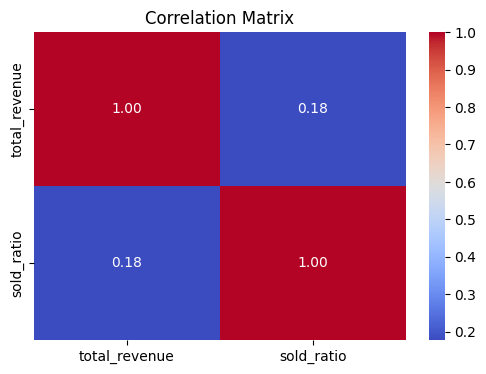

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix for numerical columns
correlation_matrix = grouped_data[["total_revenue", "sold_ratio"]].corr()

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


# Random Forest Regressor

In [9]:


# Split data by month
train_data = data[data["month"] <= 9]  # Use data up to September for training
test_data = data[data["month"] > 9]   # Use data from October onward for testing

# Feature Encoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features_train = encoder.fit_transform(train_data[["product_name", "category"]])
encoded_features_test = encoder.transform(test_data[["product_name", "category"]])

# Combine encoded features with 'month'
X_train = np.hstack((encoded_features_train, train_data[["month"]].values))
X_test = np.hstack((encoded_features_test, test_data[["month"]].values))

# Separate targets
y_train_revenue = train_data["total_revenue"].values
y_train_ratio = train_data["sold_ratio"].values
y_test_revenue = test_data["total_revenue"].values
y_test_ratio = test_data["sold_ratio"].values

# Initialize and train models
RF_model_revenue = RandomForestRegressor(random_state=42)
RF_model_ratio = RandomForestRegressor(random_state=42)

RF_model_revenue.fit(X_train, y_train_revenue)
RF_model_ratio.fit(X_train, y_train_ratio)

# Predictions
y_pred_revenue = RF_model_revenue.predict(X_test)
y_pred_ratio = RF_model_ratio.predict(X_test)

# Evaluate for total_revenue
mae_revenue = mean_absolute_error(y_test_revenue, y_pred_revenue)
rmse_revenue = np.sqrt(mean_squared_error(y_test_revenue, y_pred_revenue))

# Evaluate for sold_ratio
mae_ratio = mean_absolute_error(y_test_ratio, y_pred_ratio)
rmse_ratio = np.sqrt(mean_squared_error(y_test_ratio, y_pred_ratio))

# Print evaluation metrics
print(f"MAE for Total Revenue: {mae_revenue:.2f}")
print(f"RMSE for Total Revenue: {rmse_revenue:.2f}")
print(f"MAE for Sold Ratio: {mae_ratio:.4f}")
print(f"RMSE for Sold Ratio: {rmse_ratio:.4f}")

# Calculate MAPE for Total Revenue
mape_revenue = np.mean(np.abs((y_test_revenue - y_pred_revenue) / y_test_revenue)) * 100
accuracy_revenue = 100 - mape_revenue

# Calculate MAPE for Sold Ratio
mape_ratio = np.mean(np.abs((y_test_ratio - y_pred_ratio) / y_test_ratio)) * 100
accuracy_ratio = 100 - mape_ratio

# Print results
print(f"MAPE for Total Revenue: {mape_revenue:.2f}%")
print(f"Accuracy for Total Revenue: {accuracy_revenue:.2f}%")
print(f"MAPE for Sold Ratio: {mape_ratio:.2f}%")
print(f"Accuracy for Sold Ratio: {accuracy_ratio:.2f}%")



MAE for Total Revenue: 31689.64
RMSE for Total Revenue: 53223.71
MAE for Sold Ratio: 0.2475
RMSE for Sold Ratio: 0.2864
MAPE for Total Revenue: 683.91%
Accuracy for Total Revenue: -583.91%
MAPE for Sold Ratio: 277.74%
Accuracy for Sold Ratio: -177.74%


# XGBoost

In [11]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Feature Encoding
sales_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded_features = sales_encoder.fit_transform(grouped_data[["product_name", "category"]])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(["product_name", "category"]))

# Prepare features
X = grouped_data.drop(columns=["total_revenue", "sold_ratio", "product_name", "category"]).join(encoded_df)
y_revenue = grouped_data["total_revenue"]
y_ratio = grouped_data["sold_ratio"]

# Month-based split
train_data = grouped_data[grouped_data["month"] <= 9]  # Use months 1-9 for training
test_data = grouped_data[grouped_data["month"] > 9]    # Use months 10-12 for testing

# Train and test splits
X_train = X.loc[train_data.index]
X_test = X.loc[test_data.index]
y_train_revenue = y_revenue.loc[train_data.index]
y_test_revenue = y_revenue.loc[test_data.index]
y_train_ratio = y_ratio.loc[train_data.index]
y_test_ratio = y_ratio.loc[test_data.index]

# Train revenue model
model_revenue = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_estimators=200
)

# Train ratio model
model_ratio = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_estimators=200
)

# Fit models
model_revenue.fit(
    X_train,
    y_train_revenue,
    eval_set=[(X_test, y_test_revenue)],
    verbose=False
)

model_ratio.fit(
    X_train,
    y_train_ratio,
    eval_set=[(X_test, y_test_ratio)],
    verbose=False
)

# Make predictions
y_pred_revenue = model_revenue.predict(X_test)
y_pred_ratio = model_ratio.predict(X_test)

# Calculate metrics
mae_revenue = mean_absolute_error(y_test_revenue, y_pred_revenue)
mae_ratio = mean_absolute_error(y_test_ratio, y_pred_ratio)
rmse_revenue = np.sqrt(mean_squared_error(y_test_revenue, y_pred_revenue))

# Print results
print(f"MAE for Total Revenue: {mae_revenue:.2f}")
print(f"MAE for Sold Ratio: {mae_ratio:.4f}")
print(f"RMSE for Total Revenue: {rmse_revenue:.2f}")

# Calculate MAPE for Total Revenue
mape_revenue = np.mean(np.abs((y_test_revenue - y_pred_revenue) / y_test_revenue)) * 100
accuracy_revenue = 100 - mape_revenue

# Calculate MAPE for Sold Ratio
mape_ratio = np.mean(np.abs((y_test_ratio - y_pred_ratio) / y_test_ratio)) * 100
accuracy_ratio = 100 - mape_ratio

# Print results
print(f"MAPE for Total Revenue: {mape_revenue:.2f}%")
print(f"Accuracy for Total Revenue: {accuracy_revenue:.2f}%")
print(f"MAPE for Sold Ratio: {mape_ratio:.2f}%")
print(f"Accuracy for Sold Ratio: {accuracy_ratio:.2f}%")



MAE for Total Revenue: 283490.32
MAE for Sold Ratio: 0.0501
RMSE for Total Revenue: 530867.18
MAPE for Total Revenue: 28.64%
Accuracy for Total Revenue: 71.36%
MAPE for Sold Ratio: 10.56%
Accuracy for Sold Ratio: 89.44%


# Saving the Models and Encoder

In [12]:
joblib.dump(model_revenue,'sales_revenue_model.pkl')
joblib.dump(model_ratio,'sales_ratio_model.pkl')
joblib.dump(encoder,'sales_encoder.pkl')

['sales_encoder.pkl']

Alternative XGBoost Model with different training data fraction

In [ ]:


# Feature Encoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded_features = encoder.fit_transform(grouped_data[["product_name", "category"]])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(["product_name", "category"]))

# Prepare features
X = grouped_data.drop(columns=["total_revenue", "sold_ratio", "product_name", "category"]).join(encoded_df)
y_revenue = grouped_data["total_revenue"]
y_ratio = grouped_data["sold_ratio"]

# Regular train-test split
X_train, X_test, y_train_revenue, y_test_revenue = train_test_split(
    X, y_revenue, test_size=0.2, random_state=42
)
_, _, y_train_ratio, y_test_ratio = train_test_split(
    X, y_ratio, test_size=0.2, random_state=42
)

# Train revenue model
model_revenue = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_estimators=200
)

# Train ratio model
model_ratio = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_estimators=200
)

# Fit models
model_revenue.fit(
    X_train,
    y_train_revenue,
    eval_set=[(X_test, y_test_revenue)],
    verbose=False
)

model_ratio.fit(
    X_train,
    y_train_ratio,
    eval_set=[(X_test, y_test_ratio)],
    verbose=False
)

# Make predictions
y_pred_revenue = model_revenue.predict(X_test)
y_pred_ratio = model_ratio.predict(X_test)

# Calculate metrics
mae_revenue = mean_absolute_error(y_test_revenue, y_pred_revenue)
mae_ratio = mean_absolute_error(y_test_ratio, y_pred_ratio)
rmse_revenue = np.sqrt(mean_squared_error(y_test_revenue, y_pred_revenue))

# Print results
print(f"MAE for Total Revenue: {mae_revenue:.2f}")
print(f"MAE for Sold Ratio: {mae_ratio:.4f}")
print(f"RMSE for Total Revenue: {rmse_revenue:.2f}")

# Calculate MAPE for Total Revenue
mape_revenue = np.mean(np.abs((y_test_revenue - y_pred_revenue) / y_test_revenue)) * 100
accuracy_revenue = 100 - mape_revenue

# Calculate MAPE for Sold Ratio
mape_ratio = np.mean(np.abs((y_test_ratio - y_pred_ratio) / y_test_ratio)) * 100
accuracy_ratio = 100 - mape_ratio

# Print results
print(f"MAPE for Total Revenue: {mape_revenue:.2f}%")
print(f"Accuracy for Total Revenue: {accuracy_revenue:.2f}%")
print(f"MAPE for Sold Ratio: {mape_ratio:.2f}%")
print(f"Accuracy for Sold Ratio: {accuracy_ratio:.2f}%")


MAE for Total Revenue: 300689.11
MAE for Sold Ratio: 0.0645
RMSE for Total Revenue: 616863.72
MAPE for Total Revenue: 29.56%
Accuracy for Total Revenue: 70.44%
MAPE for Sold Ratio: 13.87%
Accuracy for Sold Ratio: 86.13%


# Ridge Regression

In [ ]:
# Split data by month
train_data = data[data["month"] <= 9]  # Use data up to September for training
test_data = data[data["month"] > 9]   # Use data from October onward for testing

# Feature Encoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features_train = encoder.fit_transform(train_data[["product_name", "category"]])
encoded_features_test = encoder.transform(test_data[["product_name", "category"]])

# Combine encoded features with 'month'
X_train = np.hstack((encoded_features_train, train_data[["month"]].values))
X_test = np.hstack((encoded_features_test, test_data[["month"]].values))

# Separate targets
y_train_revenue = train_data["total_revenue"].values
y_train_ratio = train_data["sold_ratio"].values
y_test_revenue = test_data["total_revenue"].values
y_test_ratio = test_data["sold_ratio"].values

# Initialize and train models
ridge_model_revenue = Ridge(alpha=1.0)
ridge_model_ratio = Ridge(alpha=1.0)

ridge_model_revenue.fit(X_train, y_train_revenue)
ridge_model_ratio.fit(X_train, y_train_ratio)

# Predictions
y_pred_revenue = ridge_model_revenue.predict(X_test)
y_pred_ratio = ridge_model_ratio.predict(X_test)

# Evaluate for total_revenue
mae_revenue = mean_absolute_error(y_test_revenue, y_pred_revenue)
rmse_revenue = np.sqrt(mean_squared_error(y_test_revenue, y_pred_revenue))

# Evaluate for sold_ratio
mae_ratio = mean_absolute_error(y_test_ratio, y_pred_ratio)
rmse_ratio = np.sqrt(mean_squared_error(y_test_ratio, y_pred_ratio))

# Print evaluation metrics
print(f"MAE for Total Revenue: {mae_revenue:.2f}")
print(f"RMSE for Total Revenue: {rmse_revenue:.2f}")
print(f"MAE for Sold Ratio: {mae_ratio:.4f}")
print(f"RMSE for Sold Ratio: {rmse_ratio:.4f}")

# Calculate MAPE for Total Revenue
mape_revenue = np.mean(np.abs((y_test_revenue - y_pred_revenue) / y_test_revenue)) * 100
accuracy_revenue = 100 - mape_revenue

# Calculate MAPE for Sold Ratio
mape_ratio = np.mean(np.abs((y_test_ratio - y_pred_ratio) / y_test_ratio)) * 100
accuracy_ratio = 100 - mape_ratio

# Print results
print(f"MAPE for Total Revenue: {mape_revenue:.2f}%")
print(f"Accuracy for Total Revenue: {accuracy_revenue:.2f}%")
print(f"MAPE for Sold Ratio: {mape_ratio:.2f}%")
print(f"Accuracy for Sold Ratio: {accuracy_ratio:.2f}%")

MAE for Total Revenue: 31618.67
RMSE for Total Revenue: 52975.26
MAE for Sold Ratio: 0.2476
RMSE for Sold Ratio: 0.2863
MAPE for Total Revenue: 700.50%
Accuracy for Total Revenue: -600.50%
MAPE for Sold Ratio: 284.89%
Accuracy for Sold Ratio: -184.89%
